In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.style
matplotlib.style.use("seaborn")
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
sns.color_palette("hls", 17)
import scipy.stats as st
import math

from pingouin import rcorr
import pingouin as pg

from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn import svm 
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, plot_roc_curve, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn import feature_selection #import chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
import sys
import os

from sys import platform
if platform == "darwin":
    sys.path.append(os.path.dirname(os.path.realpath(__file__)) + "/..")
    smart_nlp_path = ''
elif platform == "win32":
    sys.path.append('../')
    smart_nlp_path = os.getcwd()
    smart_nlp_path = "\\".join([smart_nlp_path.split("\\")[i] for i in range(0,len(smart_nlp_path.split("\\"))-1)]+["/"])

from module.trend_analysis_functions import *
from module.topic_model_plus_class import Topic_Model_plus

In [3]:
data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()),'data','Cleaned_ICS_predictive_model_sitreps.csv')).drop("Unnamed: 0", axis=1)

C:\Users\srandrad\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3050: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
data

,CY,DISCOVERY_DATE,INCIDENT_ID,PCT_CONTAINED_COMPLETED,START_YEAR,TOTAL_AERIAL,TOTAL_PERSONNEL,REPORT_DOY,DISCOVERY_DOY,Combined_Text,...,Infrastructure,Extreme_Weather,Ecological,Hazardous_Terrain,Floods,Dry_Weather,Severity,NUM_REPORTS,DAYS_BURING,Total_Incident_Text
0,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,80.0,2010.0,5.000000,230.000000,197,196,"['resource', 'share', 'cactus']",...,0,1,0,1,0,0,0,0,1,"['resource', 'share', 'cactus']"
1,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,60.0,2010.0,5.000000,230.000000,197,196,"['resource', 'share', 'incident', 'cactus', 'i...",...,0,1,0,1,0,0,0,1,1,"['resource', 'share', 'cactus', 'resource', 's..."
2,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,30.0,2010.0,4.000000,165.000000,197,196,"['resource', 'share', 'cactus', 'erratic', 'wi...",...,0,1,0,1,0,0,0,2,1,"['resource', 'share', 'cactus', 'resource', 's..."
3,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,100.0,2010.0,4.333333,192.333333,197,196,"['resource', 'share', 'cactus', 'cactus', 'bec...",...,0,1,0,1,0,0,0,4,1,"['resource', 'share', 'cactus', 'resource', 's..."
4,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,60.0,2010.0,4.333333,192.333333,197,196,"['resource', 'share', 'cactus', 'cactus', 'bec...",...,0,1,0,1,0,0,1,5,1,"['resource', 'share', 'cactus', 'resource', 's..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44338,2014,2014-03-15 14:30:00,2014_VAVAS1403037_BEAVER LODGE RD.,100.0,2014.0,0.000000,13.000000,74,74,"['fast', 'spread', 'field']",...,0,0,0,0,0,0,2,0,0,"['fast', 'spread', 'field']"
44339,2014,2014-03-19 14:00:00,2014_VAVAS1406037_AIRPORT MOUNTAIN,85.0,2014.0,0.000000,18.500000,80,78,"['heavy', 'plume', 'primary', 'carrier']",...,0,0,0,0,0,0,0,1,2,"['heavy', 'plume', 'primary', 'carrier']"
44340,2014,2014-08-20 13:00:00,2014_WA-WFS-513_SAND RIDGE,0.0,2014.0,1.000000,95.000000,234,232,"['heavy', 'canyon', 'river', 'mainly', 'canyon...",...,0,0,0,0,0,0,0,0,2,"['heavy', 'canyon', 'river', 'mainly', 'canyon..."
44341,2014,2014-08-20 13:00:00,2014_WA-WFS-513_SAND RIDGE,86.0,2014.0,1.000000,120.000000,235,232,"['laid', 'night', 'test', 'wind', 'remain', 'c...",...,0,0,0,0,0,0,0,1,3,"['heavy', 'canyon', 'river', 'mainly', 'canyon..."


In [5]:
predictors = ["TOTAL_PERSONNEL", "TOTAL_AERIAL", "PCT_CONTAINED_COMPLETED",
              "ACRES",  "WF_FSR", "INJURIES", "FATALITIES", "EST_IM_COST_TO_DATE", "STR_DAMAGED",
              "STR_DESTROYED", "NEW_ACRES", "INC_MGMT_ORG_ABBREV", "EVACUATION_IN_PROGRESS", 
              "Incident_region", "NUM_REPORTS", "DAYS_BURING", 'Combined_Text']
predictors_to_be_scaled = ["TOTAL_PERSONNEL", "TOTAL_AERIAL", "PCT_CONTAINED_COMPLETED",
              "ACRES",  "WF_FSR", "INJURIES", "FATALITIES", "EST_IM_COST_TO_DATE", "STR_DAMAGED",
              "STR_DESTROYED", "NEW_ACRES","NUM_REPORTS", "DAYS_BURING"]
targets = ["Traffic","Command_Transitions","Evacuations", "Inaccurate_Mapping", "Aerial_Grounding", 
           "Resource_Issues", "Injuries", "Cultural_Resources","Livestock", "Law_Violations", "Military_Base", 
           "Infrastructure", "Extreme_Weather", "Ecological", "Hazardous_Terrain", "Floods", "Dry_Weather"]

In [6]:
list(data.columns).index("Dry_Weather")

42

In [7]:
data['Traffic']

0        0
1        0
2        0
3        0
4        0
        ..
44338    0
44339    0
44340    0
44341    0
44342    0
Name: Traffic, Length: 44343, dtype: int64

In [8]:
data.iloc[:,26:42].sum().values
list(data.columns.values)[26:42]

['Traffic',
 'Command_Transitions',
 'Evacuations',
 'Inaccurate_Mapping',
 'Aerial_Grounding',
 'Resource_Issues',
 'Injuries',
 'Cultural_Resources',
 'Livestock',
 'Law_Violations',
 'Military_Base',
 'Infrastructure',
 'Extreme_Weather',
 'Ecological',
 'Hazardous_Terrain',
 'Floods']

C:\Users\srandrad\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


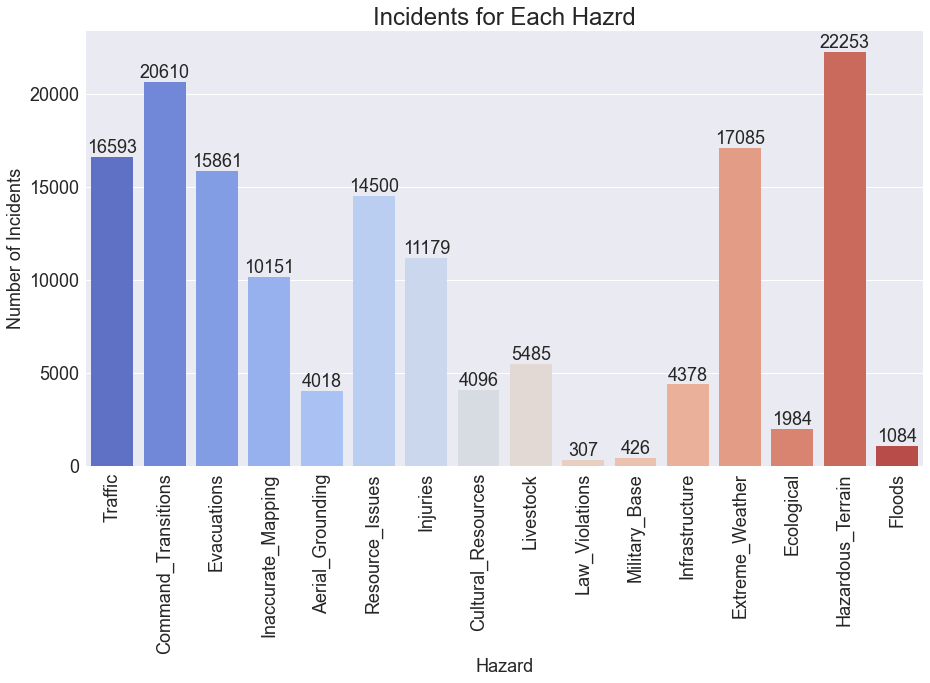

In [9]:
categories = [t.replace("_"," ") for t in targets]
categories = list(data.columns.values)[26:42]
counts = list(data.iloc[:,26:42].sum().values)
colors = cm.coolwarm(np.linspace(0, 1, len(categories)))
#sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax= sns.barplot(categories, counts, palette="coolwarm")#colors=colors)
plt.title("Incidents for Each Hazrd", fontsize=24)
plt.ylabel('Number of Incidents', fontsize=18)
plt.xlabel('Hazard', fontsize=18)
ax.set_xticklabels(categories, rotation='vertical', fontsize=18)
for label in ax.get_yticklabels():
    label.set_fontsize(18)
#ax.set_xticklabels(fontsize=18)
#adding the text labels
rects = ax.patches
labels = data.iloc[:,26:42].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
plt.show()


C:\Users\srandrad\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


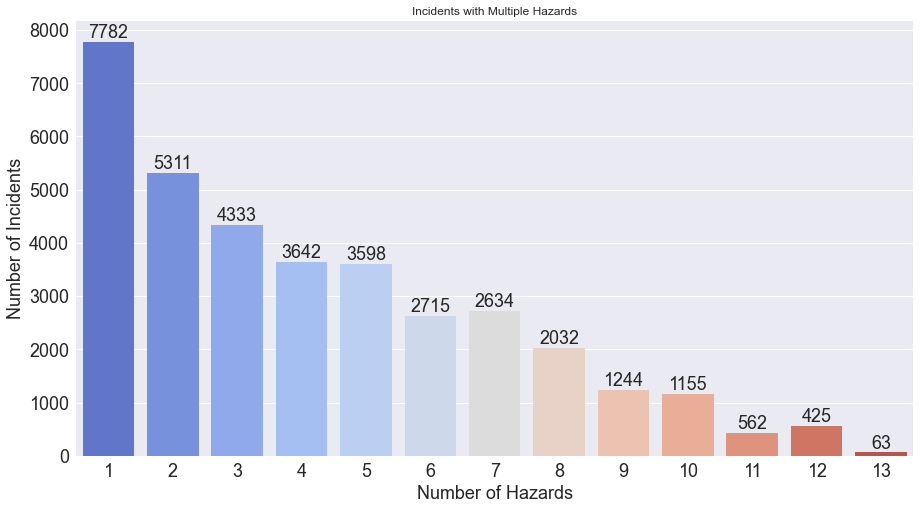

In [10]:
rowSums = data.iloc[:,26:42].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]
#sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values, palette='coolwarm')
plt.title("Incidents with Multiple Hazards")
plt.ylabel('Number of Incidents', fontsize=18)
plt.xlabel('Number of Hazards', fontsize=18)
for label in ax.get_yticklabels()+ax.get_xticklabels():
    label.set_fontsize(18)
#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
plt.show()

# Prepare the Data

In [11]:
data.isna().sum()

CY                            0
DISCOVERY_DATE                0
INCIDENT_ID                   0
PCT_CONTAINED_COMPLETED       0
START_YEAR                    0
TOTAL_AERIAL                  0
TOTAL_PERSONNEL               0
REPORT_DOY                    0
DISCOVERY_DOY                 0
Combined_Text                 0
Unique_IDs                    0
ACRES                         0
WF_FSR                        0
INJURIES                      0
FATALITIES                    0
EST_IM_COST_TO_DATE           0
STR_DAMAGED                   0
STR_DESTROYED                 0
NEW_ACRES                     0
POO_STATE                  4462
POO_LATITUDE                101
POO_LONGITUDE               101
WEATHER_CONCERNS_NARR      5914
INC_MGMT_ORG_ABBREV           0
EVACUATION_IN_PROGRESS        0
Incident_region               0
Traffic                       0
Command_Transitions           0
Evacuations                   0
Inaccurate_Mapping            0
Aerial_Grounding              0
Resource

In [12]:
def remove_quote_marks(word_list):
    word_list = word_list.strip("[]").split(", ")
    word_list = [w.replace("'","") for w in word_list]
    word_list = " ".join(word_list)
    return word_list

In [13]:
cleaned_combined_text = []
for text in data['Combined_Text']:
    cleaned_text = remove_quote_marks(text)
    cleaned_combined_text.append(cleaned_text)
data['Combined_Text'] = cleaned_combined_text

## TF-iDF model

In [14]:
#total_predictors= [pred for pred in data.columns if pred not in targets]
"""
X = data[predictors]
y = data[targets]
Xtrain_val, Xtest, ytrain_val, ytest = train_test_split(X,y, random_state=42, test_size=0.1, shuffle=True)
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain_val, ytrain_val, random_state=42, test_size=(0.1/0.9), shuffle=True)

Xtrain_text = Xtrain['Combined_Text']
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(Xtrain_text)
print(len(Xtrain['Combined_Text']), np.shape(vectorizer.transform(Xtrain_text)))
vect_text = vectorizer.transform(Xtrain_text)
for i in range(len(Xtrain)):
    print(i, vect_text[i])
    Xtrain.loc[i, 'Combined_Text'] = vect_text[i]
Xtrain.loc[:,'Combined_Text'] = vectorizer.transform(Xtrain_text)
Xval.loc[:,'Combined_Text'] =  vectorizer.transform(Xval['Combined_Text'])
Xtest[:,'Combined_Text'] = vectorizer.transform(Xtest['Combined_Text'])
"""

"\nX = data[predictors]\ny = data[targets]\nXtrain_val, Xtest, ytrain_val, ytest = train_test_split(X,y, random_state=42, test_size=0.1, shuffle=True)\nXtrain, Xval, ytrain, yval = train_test_split(Xtrain_val, ytrain_val, random_state=42, test_size=(0.1/0.9), shuffle=True)\n\nXtrain_text = Xtrain['Combined_Text']\nvectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')\nvectorizer.fit(Xtrain_text)\nprint(len(Xtrain['Combined_Text']), np.shape(vectorizer.transform(Xtrain_text)))\nvect_text = vectorizer.transform(Xtrain_text)\nfor i in range(len(Xtrain)):\n    print(i, vect_text[i])\n    Xtrain.loc[i, 'Combined_Text'] = vect_text[i]\nXtrain.loc[:,'Combined_Text'] = vectorizer.transform(Xtrain_text)\nXval.loc[:,'Combined_Text'] =  vectorizer.transform(Xval['Combined_Text'])\nXtest[:,'Combined_Text'] = vectorizer.transform(Xtest['Combined_Text'])\n"

In [15]:
X = data['Combined_Text']
y = data[targets]

In [16]:
Xtrain_val, Xtest, ytrain_val, ytest = train_test_split(X,y, random_state=42, test_size=0.1, shuffle=True)
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain_val, ytrain_val, random_state=42, test_size=(0.1/0.9), shuffle=True)

vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2', max_features=10000)
vectorizer.fit(Xtrain)
Xtrain_vec = vectorizer.transform(Xtrain)
Xval_vec =  vectorizer.transform(Xval)
Xtest_vec= vectorizer.transform(Xtest)

In [17]:
#decreasing the number of features

In [18]:
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in y:
    chi2, p = feature_selection.chi2(Xtrain_vec, ytrain[[cat]])
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [19]:
#for cat in y:
#    print("# {}:".format(cat))
#    print("  . selected features:",
#         len(dtf_features[dtf_features["y"]==cat]))
#    print("  . top features:", ",".join(
#        dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
#    print(" ")

In [20]:
vectorizer = TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(Xtrain)
Xtrain = vectorizer.transform(Xtrain)
Xval =  vectorizer.transform(Xval)
Xtest = vectorizer.transform(Xtest)

In [21]:
#for predict in predictors_to_be_scaled:
"""
minMaxScaler_cls=MinMaxScaler()
minMaxScaler_cls.fit(Xtrain)
Xtrain = minMaxScaler_cls.transform(Xtrain)
Xtest = minMaxScaler_cls.transform(Xtest)
Xval = minMaxScaler_cls.transform(Xval)
"""

'\nminMaxScaler_cls=MinMaxScaler()\nminMaxScaler_cls.fit(Xtrain)\nXtrain = minMaxScaler_cls.transform(Xtrain)\nXtest = minMaxScaler_cls.transform(Xtest)\nXval = minMaxScaler_cls.transform(Xval)\n'

### Method: classifier chain

In [22]:
classifier = ClassifierChain(LogisticRegression(max_iter=10000, multi_class='ovr'))
# Training logistic regression model on train data
classifier.fit(Xtrain, ytrain)
# predict
predictions = classifier.predict(Xtest)
# accuracy
print("Accuracy = ",accuracy_score(ytest,predictions))
print("Accuracy = ",classifier.score(Xtest,ytest))
print("f1 = ",f1_score(ytest,predictions, average='macro'))
print("\n")

Accuracy =  0.3747463359639233
Accuracy =  0.3747463359639233
f1 =  0.6878977627962641




In [23]:
classifiers = [LogisticRegression(max_iter=10000,multi_class='ovr'), RandomForestClassifier(random_state=1),
              KNeighborsClassifier(weights='distance')]#, MLPClassifier(random_state=1), RidgeClassifierCV()]
classifier_names = ['logistic regression', 'random forest', 'knn']#, 'MLP NN', 'Ridge']
accuracy = []
for clf in classifiers:
    classifier = ClassifierChain(clf)
    classifier.fit(Xtrain, ytrain)
    # predict
    predictions = classifier.predict(Xtest)
    accuracy.append(accuracy_score(ytest,predictions))

comparison = pd.DataFrame({"Base Estimator": classifier_names,
                           "Accuracy": accuracy})
                    

In [24]:
comparison

,Base Estimator,Accuracy
0,logistic regression,0.374746
1,random forest,0.542728
2,knn,0.599098


### Method: multioutput classifier

In [25]:
forest = RandomForestClassifier(random_state=1)
classifier = MultiOutputClassifier(forest, n_jobs=-1)
# Training logistic regression model on train data
classifier.fit(Xtrain, ytrain)
# predict
predictions = classifier.predict(Xtest)
# accuracy
print("Accuracy = ",accuracy_score(ytest,predictions))
print("Accuracy = ",classifier.score(Xtest, ytest))
print("f1 = ",f1_score(ytest,predictions, average='macro'))
print("\n")

Accuracy =  0.5199549041713641
Accuracy =  0.5199549041713641
f1 =  0.7681415081488656




In [26]:
depths = np.arange(2,10,1)
n_estimators = np.arange(25,350,5)
train_acc = []
test_acc = []
conf_mat = []
for depth in depths:
    forest = RandomForestClassifier(max_depth=depth, random_state=1)
    classifier = MultiOutputClassifier(forest, n_jobs=-1) #Training the model
    classifier.fit(Xtrain, ytrain)
    predictions = classifier.predict(Xtest)
    #train_acc.append(classifier.score(Xtrain, ytrain))
    test_acc.append(classifier.score(Xtest, ytest))

model_comparisons = pd.DataFrame({
    "depth": depths,
    #"train accuracy": train_acc,
    "test accuracy": test_acc
})

display(model_comparisons)
print("best depth value:", depths[np.argmax(test_acc)])
print("test f1:",  test_acc[np.argmax(test_acc)])

,depth,test accuracy
0,2,0.211725
1,3,0.217587
2,4,0.218940
3,5,0.222097
4,6,0.224803
5,7,0.231793
6,8,0.237430
7,9,0.241037


best depth value: 9
test f1: 0.24103720405862458


In [27]:
train_acc = []
test_acc = []
conf_mat = []
for n in n_estimators:
    forest = RandomForestClassifier(n_estimators=n, max_depth=9, random_state=0)#,class_weight="balanced_subsample")
    classifier = MultiOutputClassifier(forest, n_jobs=-1) #Training the model
    classifier.fit(Xtrain, ytrain)
    predictions = classifier.predict(Xtest)
    #train_acc.append(classifier.score(Xtrain, ytrain))
    test_acc.append(classifier.score(Xtest, ytest))
    
model_comparisons = pd.DataFrame({
    "n estimators": n_estimators,
    "test f1": test_acc,
})

display(model_comparisons)
print("best n value:", n_estimators[np.argmax(test_acc)])
print("test f1:",  test_acc[np.argmax(test_acc)])

,n estimators,test f1
0,25,0.228185
1,30,0.230665
2,35,0.230665
3,40,0.232244
4,45,0.236528
...,...,...
60,325,0.243517
61,330,0.243968
62,335,0.243517
63,340,0.242616


best n value: 165
test f1: 0.2450958286358512


### Method: One vs Rest classifier

In [28]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])
for category in y:
    print('**Processing {} hazards...**'.format(category))
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(Xtrain, ytrain[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(Xtest)
    print('Test accuracy is {}'.format(accuracy_score(ytest[category], prediction)))
    print("f1 = ",f1_score(ytest[category],prediction, average='macro'))
    print("confusion matrix is ",confusion_matrix(ytest[category], prediction))
    print("\n")

**Processing Traffic hazards...**
Test accuracy is 0.8284103720405862
f1 =  0.808563406063548
confusion matrix is  [[2551  252]
 [ 509 1123]]


**Processing Command_Transitions hazards...**
Test accuracy is 0.8241262683201804
f1 =  0.8214095434923752
confusion matrix is  [[2101  341]
 [ 439 1554]]


**Processing Evacuations hazards...**
Test accuracy is 0.8446448703494926
f1 =  0.8226451083762092
confusion matrix is  [[2654  222]
 [ 467 1092]]


**Processing Inaccurate_Mapping hazards...**
Test accuracy is 0.8667418263810598
f1 =  0.7707303632463213
confusion matrix is  [[3357   69]
 [ 522  487]]


**Processing Aerial_Grounding hazards...**
Test accuracy is 0.950620067643743
f1 =  0.8045614305500024
confusion matrix is  [[4025    6]
 [ 213  191]]


**Processing Resource_Issues hazards...**
Test accuracy is 0.8455467869222097
f1 =  0.8101957105751911
confusion matrix is  [[2832  169]
 [ 516  918]]


**Processing Injuries hazards...**
Test accuracy is 0.8714768883878241
f1 =  0.808078972

## Word2vec Model

In [29]:
import gensim
import gensim.downloader as gensim_api

In [30]:
X = data['Combined_Text']
y = data[targets]

In [31]:
Xtrain_val, Xtest, ytrain_val, ytest = train_test_split(X,y, random_state=42, test_size=0.1, shuffle=True)
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain_val, ytrain_val, random_state=42, test_size=(0.1/0.9), shuffle=True)

In [32]:
#for predict in predictors_to_be_scaled:
minMaxScaler_cls=MinMaxScaler()
minMaxScaler_cls.fit(Xtrain)
Xtrain = minMaxScaler_cls.transform(Xtrain)
Xtest = minMaxScaler_cls.transform(Xtest)
Xval = minMaxScaler_cls.transform(Xval)

ValueError: could not convert string to float: 'wfu primarily monitor status cultural value area assess managment action establish detect forest sup approve wfip thru stage incident complexity low planning level stage make contact hunter user area inform public post signsposting sign area future season activity notifing member community atlanta implement activity local personnel'